<a href="https://colab.research.google.com/github/BrajanNieto/MultiDiag-AI/blob/main/UNET_parpebralSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =====================================
# INSTALACIÓN DE DEPENDENCIAS
# =====================================
!pip -q install albumentations segmentation-models-pytorch timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
# =====================================
# IMPORTS GENERALES
# =====================================
import os, json, random
from pathlib import Path
from typing import List, Tuple

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

In [ ]:
# =====================================
# CONFIGURACIÓN GLOBAL
# =====================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

ROOT = Path("/content/drive/MyDrive/UNET_768")
COUNTRIES = ["India", "Italy"]

IMG_NAME = "image_768.jpg"
MASK_NAME = "mask_768.png"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Device: cuda


In [ ]:
# =====================================
# CONEXIÓN CON GOOGLE DRIVE (COLAB)
# =====================================
from google.colab import drive

drive.mount("/content/drive")

print("Drive montado correctamente")

Mounted at /content/drive
Drive montado correctamente


In [ ]:
# =====================================
# INDEXAR PARES (imagen, máscara)
# =====================================
def index_pairs(root: Path) -> List[Tuple[Path, Path]]:
    pairs = []
    for country in COUNTRIES:
        for case in sorted((root / country).iterdir()):
            img = case / IMG_NAME
            msk = case / MASK_NAME
            if img.exists() and msk.exists():
                pairs.append((img, msk))
    return pairs

pairs = index_pairs(ROOT)
print("Total pares:", len(pairs))
pairs[:3]

Total pares: 218


[(PosixPath('/content/drive/MyDrive/UNET_768/India/1/image_768.jpg'),
  PosixPath('/content/drive/MyDrive/UNET_768/India/1/mask_768.png')),
 (PosixPath('/content/drive/MyDrive/UNET_768/India/10/image_768.jpg'),
  PosixPath('/content/drive/MyDrive/UNET_768/India/10/mask_768.png')),
 (PosixPath('/content/drive/MyDrive/UNET_768/India/11/image_768.jpg'),
  PosixPath('/content/drive/MyDrive/UNET_768/India/11/mask_768.png'))]

In [ ]:
# =====================================
# SPLIT TRAIN / VALIDATION
# =====================================
random.shuffle(pairs)
split = int(0.8 * len(pairs))

train_pairs = pairs[:split]
val_pairs   = pairs[split:]

print("Train:", len(train_pairs))
print("Val:", len(val_pairs))

Train: 174
Val: 44


In [ ]:
# =====================================
# DATASET
# =====================================
class PalpebralDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, msk_path = self.pairs[idx]

        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug["image"]
            mask  = aug["mask"]

        return image, mask.unsqueeze(0)

In [ ]:
# =====================================
# TRANSFORMACIONES
# =====================================
train_tfms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.Normalize(),
    ToTensorV2(),
])

In [ ]:
# =====================================
# DATALOADERS
# =====================================
BATCH_SIZE = 2
NUM_WORKERS = 2

train_ds = PalpebralDataset(train_pairs, train_tfms)
val_ds   = PalpebralDataset(val_pairs, val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
# =====================================
# MODELO PREENTRENADO (U-NET)
# =====================================
def build_model(encoder="efficientnet-b0"):
    return smp.Unet(
        encoder_name=encoder,
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    )

model = build_model().to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
# =====================================
# LOSS (BCEWithLogits)
# =====================================
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# =====================================
# MÉTRICAS: DICE + IOU
# =====================================
@torch.no_grad()
def dice_iou_from_logits(logits, target, thr=0.5, eps=1e-6):
    """
    logits: [B,1,H,W] (salida cruda)
    target: [B,1,H,W] (0/1)
    """
    prob = torch.sigmoid(logits)
    pred = (prob > thr).float()

    inter = (pred * target).sum(dim=(1,2,3))
    pred_sum = pred.sum(dim=(1,2,3))
    targ_sum = target.sum(dim=(1,2,3))
    union = pred_sum + targ_sum - inter

    dice = (2*inter + eps) / (pred_sum + targ_sum + eps)
    iou  = (inter + eps) / (union + eps)

    return dice.mean().item(), iou.mean().item()

In [ ]:
# =====================================
# TRAIN / VALID LOOPS
# =====================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    loss_sum, dice_sum, iou_sum = 0.0, 0.0, 0.0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)  # logits
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        d, j = dice_iou_from_logits(out.detach(), y)
        loss_sum += loss.item()
        dice_sum += d
        iou_sum  += j

    n = len(loader)
    return loss_sum/n, dice_sum/n, iou_sum/n


@torch.no_grad()
def val_one_epoch(model, loader, criterion):
    model.eval()
    loss_sum, dice_sum, iou_sum = 0.0, 0.0, 0.0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        out = model(x)  # logits
        loss = criterion(out, y)

        d, j = dice_iou_from_logits(out, y)
        loss_sum += loss.item()
        dice_sum += d
        iou_sum  += j

    n = len(loader)
    return loss_sum/n, dice_sum/n, iou_sum/n


In [ ]:
# =====================================
# ENTRENAMIENTO (25 EP) + GUARDAR MEJOR
# =====================================
from datetime import datetime

SAVE_DIR = Path("/content/drive/MyDrive/UNET_768_runs")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
best_model_path = SAVE_DIR / f"best_unet_pretrained_{run_id}.pt"
best_meta_path  = SAVE_DIR / f"best_unet_pretrained_{run_id}_meta.json"

# optimizer SOLO con parámetros entrenables
optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad),
    lr=3e-5,
    weight_decay=1e-4
)

EPOCHS = 25
best_val_dice = -1.0

meta = {
    "root": str(ROOT),
    "encoder": "efficientnet-b0",
    "encoder_weights": "imagenet",
    "ft_frac": 0.3,
    "batch_size": BATCH_SIZE,
    "num_workers": NUM_WORKERS,
    "lr": 3e-5,
    "weight_decay": 1e-4,
    "best_model_path": str(best_model_path)
}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_dice, tr_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_dice, va_iou = val_one_epoch(model, val_loader, criterion)

    print(f"Epoch {epoch:02d} | "
          f"Train: loss {tr_loss:.4f} dice {tr_dice:.4f} iou {tr_iou:.4f} | "
          f"Val: loss {va_loss:.4f} dice {va_dice:.4f} iou {va_iou:.4f}")

    if va_dice > best_val_dice:
        best_val_dice = va_dice
        torch.save(model.state_dict(), best_model_path)

        meta["best_val_dice"] = float(best_val_dice)
        meta["best_val_iou"]  = float(va_iou)
        meta["best_epoch"]    = int(epoch)

        with open(best_meta_path, "w") as f:
            json.dump(meta, f, indent=2)

        print(f"✅ Nuevo mejor modelo guardado: {best_model_path}")
        print(f"   Mejor Val Dice: {best_val_dice:.4f}")


Epoch 01 | Train: loss 0.0738 dice 0.8448 iou 0.7360 | Val: loss 0.0834 dice 0.7741 iou 0.6427
✅ Nuevo mejor modelo guardado: /content/drive/MyDrive/UNET_768_runs/best_unet_pretrained_20260121_193635.pt
   Mejor Val Dice: 0.7741
Epoch 02 | Train: loss 0.0683 dice 0.8422 iou 0.7325 | Val: loss 0.0814 dice 0.7815 iou 0.6528
✅ Nuevo mejor modelo guardado: /content/drive/MyDrive/UNET_768_runs/best_unet_pretrained_20260121_193635.pt
   Mejor Val Dice: 0.7815
Epoch 03 | Train: loss 0.0639 dice 0.8457 iou 0.7372 | Val: loss 0.0746 dice 0.7702 iou 0.6390
Epoch 04 | Train: loss 0.0610 dice 0.8426 iou 0.7328 | Val: loss 0.0734 dice 0.7719 iou 0.6410
Epoch 05 | Train: loss 0.0582 dice 0.8434 iou 0.7339 | Val: loss 0.0708 dice 0.7703 iou 0.6397
Epoch 06 | Train: loss 0.0551 dice 0.8452 iou 0.7364 | Val: loss 0.0655 dice 0.7733 iou 0.6434
Epoch 07 | Train: loss 0.0524 dice 0.8479 iou 0.7405 | Val: loss 0.0657 dice 0.7776 iou 0.6481
Epoch 08 | Train: loss 0.0503 dice 0.8481 iou 0.7411 | Val: loss 0.

In [ ]:
# =====================================
# VISUALIZAR PREDICCIÓN (IMG | GT | PROB | MASK)
# =====================================
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def show_batch_predictions(model, loader, n=3, thr=0.5):
    model.eval()

    # tomar un batch cualquiera (val o test)
    x, y = next(iter(loader))
    x = x.to(DEVICE)
    y = y.to(DEVICE)

    # forward
    logits = model(x)
    probs = torch.sigmoid(logits)
    pred  = (probs > thr).float()

    # pasar a cpu para visualizar
    x = x.cpu()
    y = y.cpu()
    probs = probs.cpu()
    pred = pred.cpu()

    n = min(n, x.shape[0])

    for i in range(n):
        img = x[i].permute(1, 2, 0).numpy()   # HWC
        gt  = y[i, 0].numpy()
        pb  = probs[i, 0].numpy()
        pr  = pred[i, 0].numpy()

        plt.figure(figsize=(14,4))

        plt.subplot(1,4,1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,4,2)
        plt.imshow(gt, cmap="gray")
        plt.title("GT mask")
        plt.axis("off")

        plt.subplot(1,4,3)
        plt.imshow(pb, cmap="gray")
        plt.title("Pred prob")
        plt.axis("off")

        plt.subplot(1,4,4)
        plt.imshow(pr, cmap="gray")
        plt.title(f"Pred mask (thr={thr})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

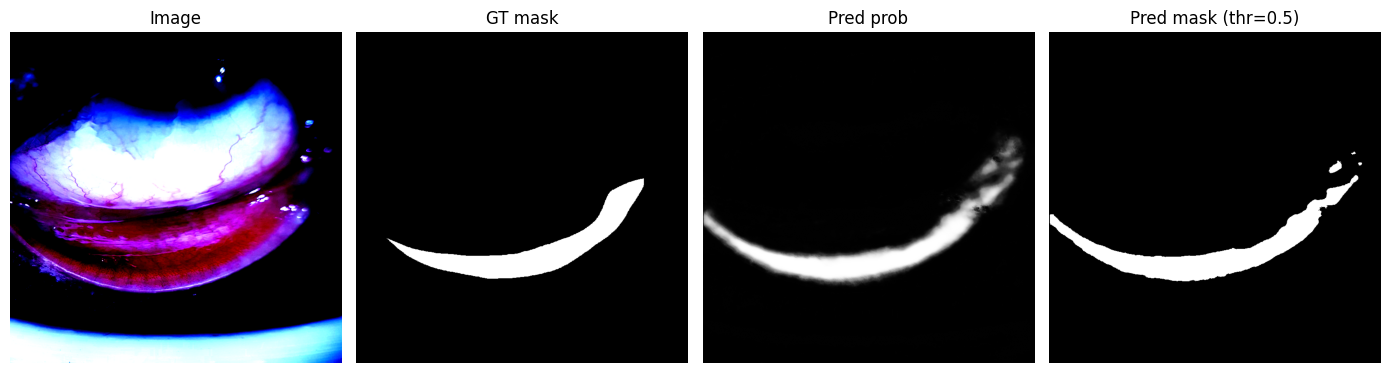

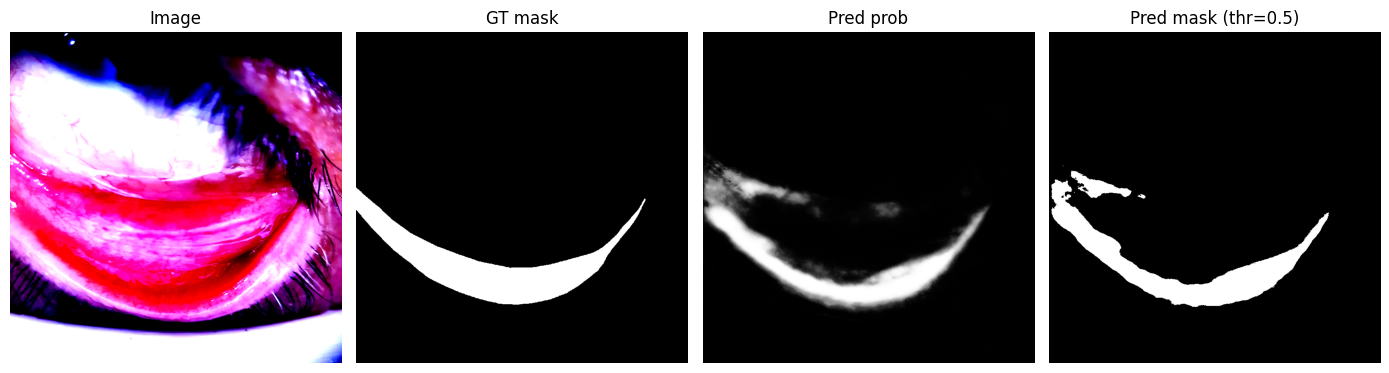

In [ ]:
show_batch_predictions(model, val_loader, n=20, thr=0.5)